## Import libs

In [1]:
import json
import nltk
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
import gc
import numpy as np
from torch.utils.data import Dataset, DataLoader
from insights import load_data, extract_data, get_insights, plot_histogram, plot_bar_chart
from preprocessing import preprocess_with_stopwords_with_lemmatization, preprocess_without_stopwords_with_lemmatization, preprocess_with_stopwords_without_lemmatization, preprocess_without_stopwords_without_lemmatization
from classification import train_and_evaluate_nb, train_and_evaluate_ffnn, load_json_data, prepare_train_test_split, move_samples_between_sets

## Task 1: Extract insights from data

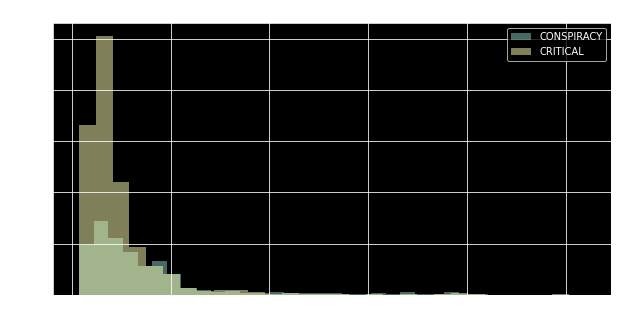

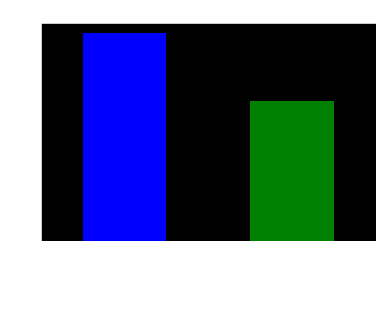

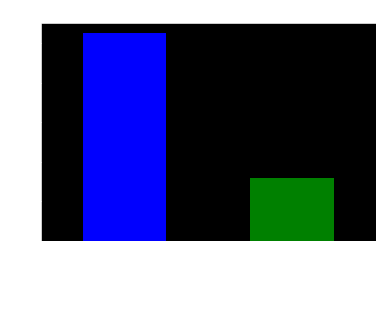

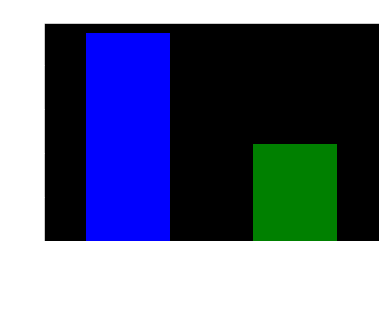

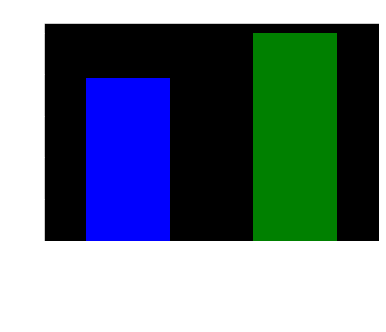

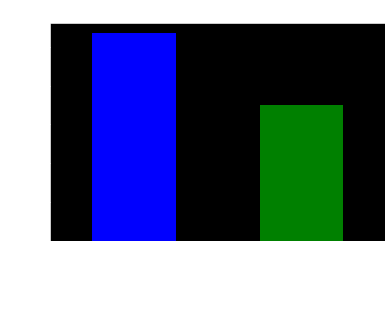

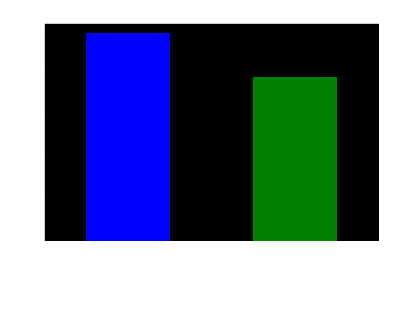

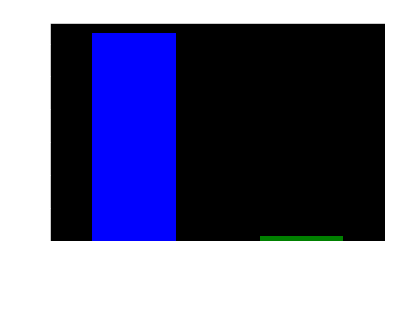

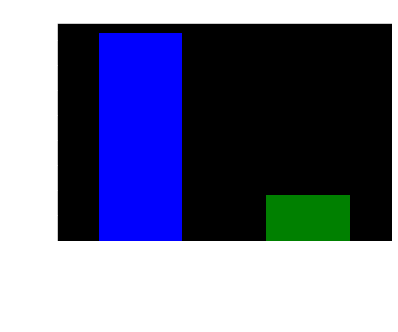

In [3]:
# Load and extract data
data = load_data('data/Oppositional_thinking_analysis_dataset.json')

# Extract text and category from the data.
data_extracted = extract_data(data)

# Convert to DataFrame
df = pd.DataFrame(data_extracted)

# Adding new features
df = get_insights(df)

# Plot distributions and bar charts. (df, category, title, xlabel, ylabel):
plot_histogram(df, 'text_length', 'Text Length Distribution by Category', 'Number of Words', 'Frequency')
plot_bar_chart(df, 'unique_word_count', 'Average Number of Unique Words by Category', 'Average Unique Words')
plot_bar_chart(df, 'uppercase_word_count', 'Average Number of Uppercase Words by Category', 'Average Uppercase Words')
plot_bar_chart(df, 'exclamation_count', 'Average Number of Exclamation Marks by Category', 'Average Exclamation Marks')

# Plot feature-based bar charts
plot_bar_chart(df, 'contains_link', 'Proportion of Texts Containing Links by Category', 'Proportion Containing Links')
plot_bar_chart(df, 'contains_parentheses', 'Proportion of Texts Containing Parentheses by Category', 'Proportion Containing Parentheses')
plot_bar_chart(df, 'contains_quotation_marks', 'Proportion of Texts Containing Quotation Marks by Category', 'Proportion Containing Quotation Marks')
plot_bar_chart(df, 'contains_5G', 'Proportion of Texts Containing "5G" or "5 G" by Category', 'Proportion Containing "5G" or "5 G"')
plot_bar_chart(df, 'contains_bill_gates', 'Proportion of Texts Containing "Bill Gates" by Category', 'Proportion Containing "Bill Gates"')

## Task 2: Pre-processing

### Load the input text file and extract texts and labels

In [4]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load the file with texts
with open('data/Oppositional_thinking_analysis_dataset.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract text and category
data_extracted = [{'text': entry['text'], 'category': entry['category']} for entry in data]

# Map categories into 0 and 1
category_mapping = {
    'CRITICAL': 0,     
    'CONSPIRACY': 1
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimitrijschulz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dimitrijschulz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Preprocess the input texts in different ways and save each example in a json file

In [ ]:
# 3 min
# Save preprocessed text as json files into data/ folder
def preprocess_and_save(data, preprocess_func, file_name):
    df = pd.DataFrame(data)
    df['preprocessed_text'] = df['text'].apply(preprocess_func)
    df = df.drop('text', axis=1)
    df['category'] = df['category'].apply(lambda x: category_mapping[x])
    df.to_json(file_name, orient='records', lines=True, force_ascii=False)
    print(df.head())
    return df

# List of preprocessing configurations
preprocessing_configs = [
    ('preprocess_with_stopwords_with_lemmatization', preprocess_with_stopwords_with_lemmatization, 'data/preprocess_with_stopwords_with_lemmatization.json'),
    ('preprocess_without_stopwords_with_lemmatization', preprocess_without_stopwords_with_lemmatization, 'data/preprocess_without_stopwords_with_lemmatization.json'),
    ('preprocess_with_stopwords_without_lemmatization', preprocess_with_stopwords_without_lemmatization, 'data/preprocess_with_stopwords_without_lemmatization.json'),
    ('preprocess_without_stopwords_without_lemmatization', preprocess_without_stopwords_without_lemmatization, 'data/preprocess_without_stopwords_without_lemmatization.json')
]

# Dictionary to store preprocessed DataFrames
preprocessed_data = {}

# Apply preprocessing and save results
for name, func, file_name in preprocessing_configs:
    preprocessed_data[name] = preprocess_and_save(data_extracted, func, file_name)

## Task 3: Vectorization and Text classification

### Load data with different pre-processing steps

In [5]:
# Load the preprocessed JSON data (from Task 2)
data_files = [
    'data/preprocess_with_stopwords_with_lemmatization.json',
    'data/preprocess_without_stopwords_with_lemmatization.json',
    'data/preprocess_with_stopwords_without_lemmatization.json',
    'data/preprocess_without_stopwords_without_lemmatization.json'
]

### Define different vectorization Models

In [6]:
# Vectorizers to compare
vectorizers = [
    (TfidfVectorizer(ngram_range=(1, 1)), 'TfidfVectorizer1'), # Unigrams TfidfVectorizer
    (TfidfVectorizer(ngram_range=(2, 2)), 'TfidfVectorizer2'), # Bigrams TfidfVectorizer
    (TfidfVectorizer(ngram_range=(3, 3)), 'TfidfVectorizer3'), # Trigrams TfidfVectorizer
    (CountVectorizer(ngram_range=(1, 1)), 'CountVectorizer1'), # Unigrams CountVectorizer
    (CountVectorizer(ngram_range=(2, 2)), 'CountVectorizer2'), # Bigrams CountVectorizer
    (CountVectorizer(ngram_range=(3, 3)), 'CountVectorizer3'),  # Trigrams CountVectorizer
]

### Naïve Bayes Model with different vectorizers and pre-processing steps

#### Train Naïve Bayes Model

In [7]:
# Initialize dictionaries to store results and misclassifications
results = {}
misclassifications = {}
# I will save missclassified text in this folder for NB
nb_res_path = "data/nb_results/"
os.makedirs(nb_res_path, exist_ok=True)

# Iterate over each data file and each vectorizer
for data_file in data_files:
    # Load data
    data = load_json_data(data_file)
    
    # Prepare train and test sets
    X_train, X_test, y_train, y_test = prepare_train_test_split(data, "nb")
    print(100*"-")
    print(f"\nData file: {data_file}")
    print("Original train set length:", len(X_train))
    print("Original test set length:", len(X_test))
    
    # Count classes in y_train
    train_class_counts = {}
    for label in y_train:
        if label in train_class_counts:
            train_class_counts[label] += 1
        else:
            train_class_counts[label] = 1

    print("Train set class counts:")
    print(train_class_counts)

    # Count classes in y_test
    test_class_counts = {}
    for label in y_test:
        if label in test_class_counts:
            test_class_counts[label] += 1
        else:
            test_class_counts[label] = 1

    print("\nTest set class counts:")
    print(test_class_counts)
    
    # Move samples of the 'CRITICAL' category (labeled as 0)
    X_train, y_train, X_test, y_test = move_samples_between_sets(X_train, y_train, X_test, y_test)
    
    print("\nAfter undersampling:")
    print("Train set length:", len(X_train))
    print("Test set length:", len(X_test))
    print("Train and test sets loaded for preprocessed data file. Training with this preprocessed file:\n")
    
    # Count classes in y_train
    train_class_counts = {}
    for label in y_train:
        if label in train_class_counts:
            train_class_counts[label] += 1
        else:
            train_class_counts[label] = 1

    print("Train set class counts:")
    print(train_class_counts)

    # Count classes in y_test
    test_class_counts = {}
    for label in y_test:
        if label in test_class_counts:
            test_class_counts[label] += 1
        else:
            test_class_counts[label] = 1

    print("\nTest set class counts:")
    print(test_class_counts)
    # Dictionary to store classification reports and misclassification info
    results[data_file] = {}
    misclassifications[data_file] = {}

    # Remove 'data/' prefix from data_file for saving the file name
    file_name_without_data = data_file.replace('data/', '')

    # Iterate over each vectorizer for this data file
    for vectorizer, vectorizer_name in vectorizers:
        report, misclassified_data_nb, misclassified_count, total = train_and_evaluate_nb(vectorizer, X_train['preprocessed_text'], X_test['preprocessed_text'], y_train, y_test, data_file, vectorizer_name)
        results[data_file][vectorizer_name] = report
        misclassifications[data_file][vectorizer_name] = (misclassified_count, total)
        # Save misclassified examples to JSON file
        with open(f"{nb_res_path}{file_name_without_data}_{vectorizer_name}_misclassified.json", 'w') as f:
            json.dump(misclassified_data_nb, f, indent=4)


----------------------------------------------------------------------------------------------------

Data file: data/preprocess_with_stopwords_with_lemmatization.json
Original train set length: 3200
Original test set length: 800
Train set class counts:
{1: 1103, 0: 2097}

Test set class counts:
{0: 524, 1: 276}

After undersampling:
Train set length: 2450
Test set length: 1550
Train and test sets loaded for preprocessed data file. Training with this preprocessed file:

Train set class counts:
{1: 1103, 0: 1347}

Test set class counts:
{0: 1274, 1: 276}
Vectorizer: TfidfVectorizer1

F1 Score (weighted): 0.8942
Number of misclassified examples out of 1550 examples : 165
**************************************************
Vectorizer: TfidfVectorizer2

F1 Score (weighted): 0.8688
Number of misclassified examples out of 1550 examples : 208
**************************************************
Vectorizer: TfidfVectorizer3

F1 Score (weighted): 0.8478
Number of misclassified examples out of 1550

#### Visualize Statistics for Bayes

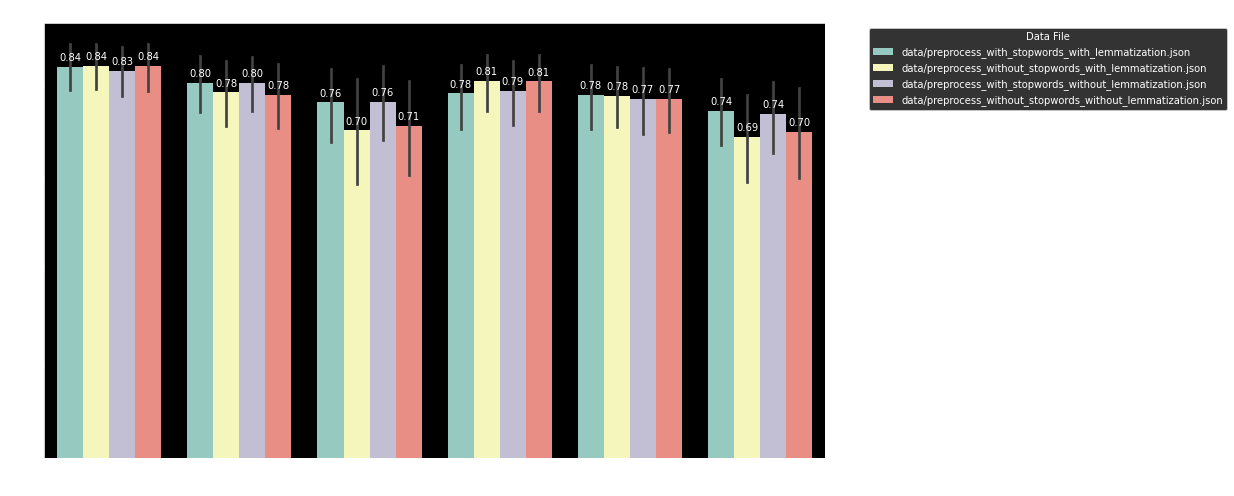

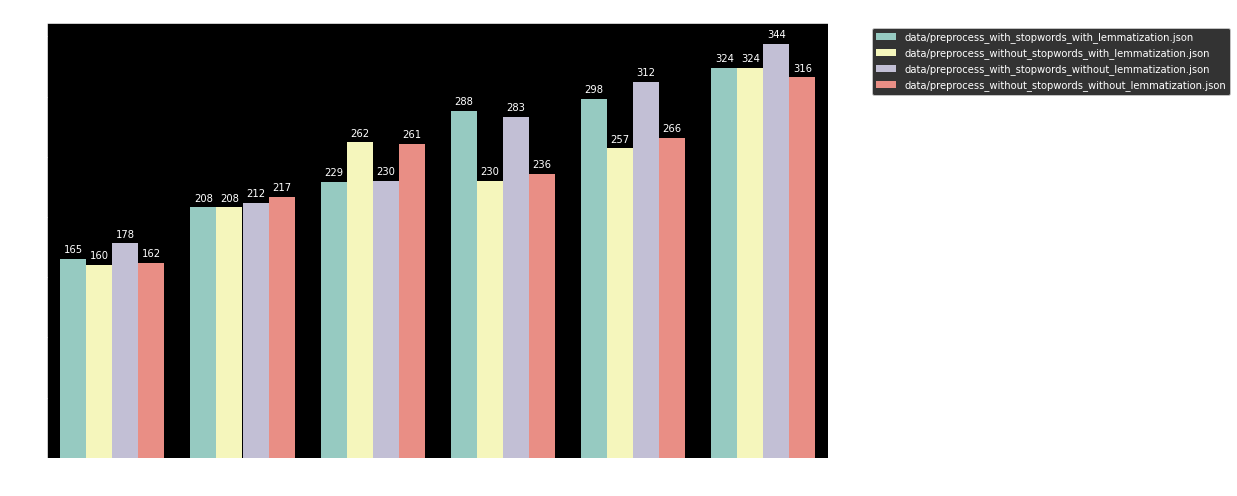

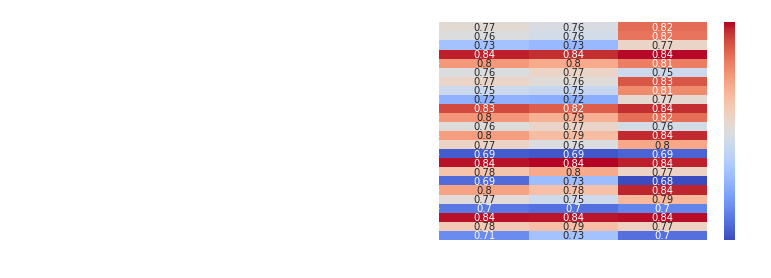

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to a DataFrame for visualization
def results_to_dataframe(results):
    records = []
    for data_file, vectorizer_reports in results.items():
        for vectorizer_name, report in vectorizer_reports.items():
            for metric in ['precision', 'recall', 'f1-score']:
                for label, scores in report.items():
                    if isinstance(scores, dict):
                        records.append({
                            'Data File': data_file,
                            'Vectorizer': vectorizer_name,
                            'Label': label,
                            'Metric': metric,
                            'Score': scores[metric]
                        })
    return pd.DataFrame(records)

# Create DataFrame from results
df_results = results_to_dataframe(results)

# Create a DataFrame for misclassifications
misclass_records = []
for data_file, vectorizer_data in misclassifications.items():
    for vectorizer_name, (misclassified, total) in vectorizer_data.items():
        misclass_records.append({
            'Data File': data_file,
            'Vectorizer': vectorizer_name,
            'Misclassified': misclassified,
            'Total': total
        })
df_misclassifications = pd.DataFrame(misclass_records)

# Plotting the scores
plt.figure(figsize=(14, 8))
score_plot = sns.barplot(x='Vectorizer', y='Score', hue='Data File', data=df_results)

# Annotate bars with score values
for p in score_plot.patches:
    score_plot.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')

plt.title('Scores Comparison per Vectorizer and Data File')
plt.xlabel('Vectorizer')
plt.ylabel('Score')
plt.legend(title='Data File', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Plotting the misclassifications (unchanged from previous code)
plt.figure(figsize=(14, 8))
misclass_plot = sns.barplot(x='Vectorizer', y='Misclassified', hue='Data File', data=df_misclassifications)

# Annotate bars with misclassification values
for p in misclass_plot.patches:
    misclass_plot.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', 
                           xytext=(0, 9), 
                           textcoords='offset points')

plt.title('Number of Misclassifications per Vectorizer and Data File')
plt.xlabel('Vectorizer')
plt.ylabel('Number of Misclassifications')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Additional visualization example: Heatmap (unchanged from previous code)
pivot_table = df_results.pivot_table(values='Score', index=['Data File', 'Vectorizer'], columns='Metric')
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Vectorizer Performance')
plt.show();

#### Error analysis

In [ ]:
# REPORT

### FFNN Model

##### Define Hyperparameters and FFNN

In [ ]:
# Hyperparameters
#input_size = 0  # vectorizers output
hidden_size1 = 64
hidden_size2 = 32
output_size = 1
dropout_rate = 0.4
learning_rate = 0.001
batch_size = 32
epochs = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PyTorch Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.tensor(self.y[idx], dtype=torch.float32)

    
# FFNN Model class
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid() # Will use nn.BCELoss()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x) # Will use nn.BCELoss()
        return x


##### Train and evaluate FFNN Models

In [ ]:
# 
torch.cuda.empty_cache()
gc.collect()

# Iterate over each data file and each vectorizer
for data_file in data_files:
    data = load_json_data(data_file)
    X_train, X_test, y_train, y_test = prepare_train_test_split(data, "ffnn")
    X_train, y_train, X_test, y_test = move_samples_between_sets(X_train, y_train, X_test, y_test)
    print(100*"-")
    for vectorizer, vectorizer_name in vectorizers:
        vectorizer.fit(X_train)  # Fit the vectorizer only on training data
        X_train_vec = vectorizer.transform(X_train).toarray()
        X_test_vec = vectorizer.transform(X_test).toarray()
        
        # Create datasets and dataloaders
        train_dataset = TextDataset(X_train_vec, y_train.values)
        test_dataset = TextDataset(X_test_vec, y_test.values)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print(f"\nData file: {data_file} | Vectorizer: {vectorizer_name}")
        
        # Initialize model, criterion, and optimizer
        model = FFNN(input_size=X_train_vec.shape[1],
                     hidden_size1=hidden_size1,
                     hidden_size2=hidden_size2,
                     output_size=output_size,
                     dropout_rate=dropout_rate).to(device)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Train and evaluate FFNN model
        train_and_evaluate_ffnn(model, train_loader, test_loader, criterion, optimizer, device, epochs)

##### Error Analysis

In [ ]:
# REPORT

## Task 4: Textual similarity

In [1]:
# Define the sentences
sentences = [
    "coronavirus death joe biden first ten month office surpass death toll trump",
    "nolte bidensanity unvaccinated illegal alien shipped dozen state coronavirus fear rage",
    "new world order want people dead rest slave make sure dont child satanist want eat",
    "exclusive govkristi noem joe biden rationing life saving coronavirus medicine political reason",
    "short news clip alleged swine flu pandemic exaggerated position power maximise profit",
    "postal worker union role federal government mandate vaccination",
    "new world order ally uniparty want destroy united stateswe must let themstay alert keep head swivel",
    "quote yetthere official definition long covid diagnostic criterion condition new zealand ministry health",
    "report climate change pose threat much planetincluding american sovereignty",
    "ukraine drama staged event like covid wasreal limited scale war blown proportion pub four",
    "stanley plotkin admits use aborted baby vaccinesyou see contempt oozing jew ca nt youfull deposition",
    "carlson america lost religion replaced cult coronavirus",
    "greta thunberg biden admin ready act seriously need climate crisis",
    "made take pig vaccine would think people would upset satanist resistance stop satan info saveusnoworguk",
    "vaccine bio chemical weapon warn people got electron microscope image antenna contaminant want dead"
]

# Step 1: Tokenize and get unique words
def tokenize(sentence):
    return sentence.split()

def get_unique_words(sentences):
    unique_words = set()
    for sentence in sentences:
        words = tokenize(sentence)
        unique_words.update(words)
    return sorted(list(unique_words))

# Step 2: Compute term frequencies for each sentence
def compute_term_frequencies(sentences, unique_words):
    term_freqs = []
    for sentence in sentences:
        words = tokenize(sentence)
        freq_vector = np.zeros(len(unique_words))
        for word in words:
            index = unique_words.index(word)
            freq_vector[index] += 1
        term_freqs.append(freq_vector)
    return np.array(term_freqs)

# Step 3: Compute cosine similarity manually
def compute_cosine_similarity_matrix(sentences):
    unique_words = get_unique_words(sentences)
    term_freqs = compute_term_frequencies(sentences, unique_words)
    
    num_sentences = len(sentences)
    similarity_matrix = np.zeros((num_sentences, num_sentences))
    
    for i in range(num_sentences):
        for j in range(num_sentences):
            vector_i = term_freqs[i]
            vector_j = term_freqs[j]
            dot_product = np.dot(vector_i, vector_j)
            norm_i = np.linalg.norm(vector_i)
            norm_j = np.linalg.norm(vector_j)
            if norm_i != 0 and norm_j != 0:
                similarity = dot_product / (norm_i * norm_j)
            else:
                similarity = 0.0  # handle division by zero
            similarity_matrix[i][j] = similarity
    
    return similarity_matrix

# Compute cosine similarity matrix for the given sentences
cosine_sim_matrix = compute_cosine_similarity_matrix(sentences)

# Print the cosine similarity matrix in a square format
print("Cosine Similarity Matrix (15x15):")
print("\t" + "\t".join([f"Se {i+1}" for i in range(len(sentences))]))
for i in range(len(sentences)):
    print(f"Se {i+1}\t" + "\t".join([f"{cosine_sim_matrix[i][j]:.2f}" for j in range(len(sentences))]))



Cosine Similarity Matrix (15x15):
	Se 1	Se 2	Se 3	Se 4	Se 5	Se 6	Se 7	Se 8	Se 9	Se 10	Se 11	Se 12	Se 13	Se 14	Se 15
Se 1	1.00	0.08	0.00	0.23	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.10	0.08	0.00	0.00
Se 2	0.08	1.00	0.00	0.09	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.11	0.00	0.00	0.00
Se 3	0.00	0.00	1.00	0.00	0.00	0.00	0.30	0.07	0.00	0.00	0.00	0.00	0.00	0.12	0.26
Se 4	0.23	0.09	0.00	1.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.11	0.09	0.00	0.00
Se 5	0.00	0.00	0.00	0.00	1.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
Se 6	0.00	0.00	0.00	0.00	0.00	1.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
Se 7	0.00	0.00	0.30	0.00	0.00	0.00	1.00	0.07	0.00	0.00	0.00	0.00	0.00	0.00	0.07
Se 8	0.00	0.00	0.07	0.00	0.00	0.00	0.07	1.00	0.00	0.07	0.00	0.00	0.00	0.00	0.00
Se 9	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	1.00	0.00	0.00	0.00	0.11	0.00	0.00
Se 10	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.07	0.00	1.00	0.00	0.00	0.00	0.00	0.00
Se 11	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	1.00	0.00	0.00	0.00	0.00
Se

### Bonus Task: Textual similarity